# Accessing evolutionary Coeval data

When you run `run_coeval` with non-saturated spin temperature fluctuations (or various other options, such as inhomogeneous recombinations), *or* you run `run_lightcone`, many coeval simulation cubes at higher redshifts are computed, to generate the evolution up to the redshift you requested (or in the case of lightcones, to be interpolated over). By default, with `write=True`, all these boxes are saved to the cache (or a folder of your choice). What is the best way to access that data?

Looking at the output datafiles themselves (a bunch of `.h5` files) is fairly confusing -- the files are saved with names based on inscrutable hashes. You can use the builtin command-line functionality `21cmfast query` to identify what's what, but that can be a bit clunky. You could also just run `run_coeval` at the redshift you care about, with the same input parameters -- this will just return the cached object. But this is also a bit clunky, and requires you to know the redshifts that were calculated during the evolution.

Never fear though -- both the `Coeval` and `LightCone` objects have a `get_cached_data()` method that will find these files for you! Let's see how it works.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import py21cmfast as p21c
from tempfile import mkdtemp

# For plotting the cubes, we use the plotting submodule:
# For interacting with the cache
from py21cmfast import plotting

We're going to make a temporary cache, so that this notebook produces the same output every time. 

If you want to hold on to each computed OutputStruct, you can specify your own folder in `OutputCache` and read/copy/write/delete the files as needed:

In [2]:
cache = p21c.OutputCache(mkdtemp())

To control which outputs are cached, one can pass a `CacheConfig` object to the `write` arguments of the lightcone and coeval functions.

In [3]:
cacheconfig = p21c.CacheConfig.on()
cacheconfig

CacheConfig(initial_conditions=True, perturbed_field=True, spin_temp=True, ionized_box=True, brightness_temp=True, halobox=True, perturbed_halo_field=True, halo_field=True, xray_source_box=True)

Passing `True` or `False` to the `write` argument turns caching for all objects on and off respectively

## Create an example box

We first run a coeval box to have something to read later:

In [4]:
inputs = p21c.InputParameters.from_template(
    'simple',
    random_seed=1234,
    node_redshifts=(6,7,8,9,10,11,12,13,14,15,16,17,18,19,20),
).evolve_input_structs(DIM=300,BOX_LEN=100,HII_DIM=100)

coevals = p21c.run_coeval(
    out_redshifts=(6,16),
    inputs=inputs,
    write=cacheconfig,
    cache=cache,
)

## Accessing cached data from `Coeval`

If you have the exact object you want to load, you can simply pass it in to the `find_existing` method of the OutputCache to get the path, then read it using our hdf5 submodule

In [5]:
brightness_temp_z16 = p21c.BrightnessTemp.new(redshift=inputs.node_redshifts[10],inputs=inputs)
path = cache.find_existing(brightness_temp_z16)
brightness_temp_z16 = p21c.io.h5.read_output_struct(path)

The output is an `OutputStruct` of whatever kind you requested:

In [6]:
brightness_temp_z16

BrightnessTemp(inputs=cosmo_params: CosmoParams(SIGMA_8=0.8102, hlittle=0.6766, OMm=0.30964144154550644, OMb=0.04897468161869667, POWER_INDEX=0.9665, OMn=0.0, OMk=0.0, OMr=8.6e-05, OMtot=1.0, Y_He=0.24, wl=-1.0)
simulation_options: SimulationOptions(BOX_LEN=100.0, HII_DIM=100, DIM=300, NON_CUBIC_FACTOR=1.0, N_THREADS=1, SAMPLER_MIN_MASS=100000000.0, SAMPLER_BUFFER_FACTOR=2.0, N_COND_INTERP=200, N_PROB_INTERP=400, MIN_LOGPROB=-12.0, HALOMASS_CORRECTION=0.89, PARKINSON_G0=1.0, PARKINSON_y1=0.0, PARKINSON_y2=0.0, Z_HEAT_MAX=35.0, ZPRIME_STEP_FACTOR=1.02, INITIAL_REDSHIFT=300.0, DELTA_R_FACTOR=1.1, DENSITY_SMOOTH_RADIUS=0.2, DEXM_OPTIMIZE_MINMASS=100000000000.0, DEXM_R_OVERLAP=2.0, CORR_STAR=0.5, CORR_SFR=0.2, CORR_LX=0.2)
matter_options: MatterOptions(HMF='ST', USE_RELATIVE_VELOCITIES=False, POWER_SPECTRUM='EH', PERTURB_ON_HIGH_RES=False, NO_RNG=False, USE_INTERPOLATION_TABLES='hmf-interpolation', MINIMIZE_MEMORY=False, KEEP_3D_VELOCITIES=False, SAMPLE_METHOD='MASS-LIMITED', FILTER='spher

You can also Construct a `RunCache` instance, which contains the filenames of every box needed for the run, and find it there

In [7]:
runcache = p21c.RunCache.from_inputs(cache=cache,inputs=inputs)
brightness_temp_z16 = runcache.get_output_struct_at_z(
        kind="BrightnessTemp",
        z=16.0,
        match_z_within=0.01,
)

To list all objects currently stored in your cache, use `list_datasets()` with filters for output type, input parameters, redshift and seed. Pass None for each filter to output everything

In [8]:
cache.list_datasets(
    kind=None,
    inputs=None,
    redshift=None,
    all_seeds=True,
)

[PosixPath('/tmp/tmp7yxoj566/a3c1b1a96d4c210044967fb2f60d8ed1/1234/InitialConditions.h5'),
 PosixPath('/tmp/tmp7yxoj566/a3c1b1a96d4c210044967fb2f60d8ed1/1234/01a01b1fe697e22e1682177d07c45412/6.0000/PerturbedField.h5'),
 PosixPath('/tmp/tmp7yxoj566/a3c1b1a96d4c210044967fb2f60d8ed1/1234/01a01b1fe697e22e1682177d07c45412/6.0000/38a740b6339bfd71c4277b36930df01f/BrightnessTemp.h5'),
 PosixPath('/tmp/tmp7yxoj566/a3c1b1a96d4c210044967fb2f60d8ed1/1234/01a01b1fe697e22e1682177d07c45412/6.0000/38a740b6339bfd71c4277b36930df01f/IonizedBox.h5'),
 PosixPath('/tmp/tmp7yxoj566/a3c1b1a96d4c210044967fb2f60d8ed1/1234/01a01b1fe697e22e1682177d07c45412/7.0000/PerturbedField.h5'),
 PosixPath('/tmp/tmp7yxoj566/a3c1b1a96d4c210044967fb2f60d8ed1/1234/01a01b1fe697e22e1682177d07c45412/7.0000/38a740b6339bfd71c4277b36930df01f/BrightnessTemp.h5'),
 PosixPath('/tmp/tmp7yxoj566/a3c1b1a96d4c210044967fb2f60d8ed1/1234/01a01b1fe697e22e1682177d07c45412/7.0000/38a740b6339bfd71c4277b36930df01f/IonizedBox.h5'),
 PosixPath('/tmp/

Note that the directory structure in the cache is split up into several hashes which represent various parts of the input structure and redshift. This ensures we don't re-calculate the same boxes twice unless we explicitly pass `regenerate=True` to our functions

We can proceed to plot the brightness temperature that we read from cache

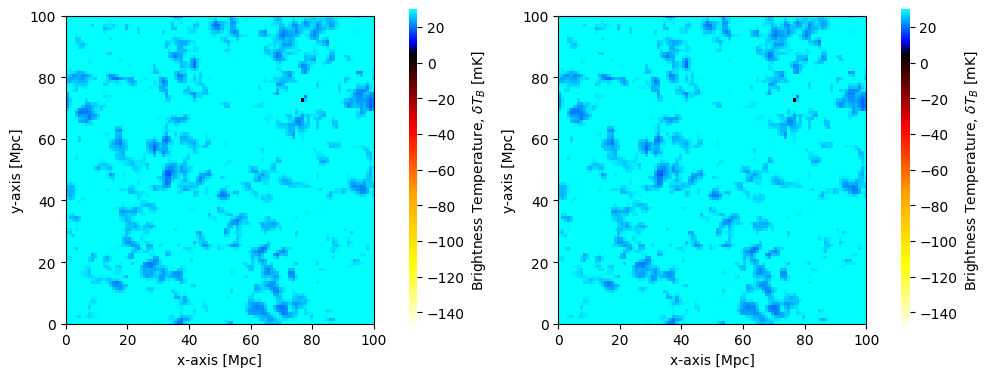

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plotting.coeval_sliceplot(coevals[0], ax=ax[0], fig=fig)
plotting.coeval_sliceplot(brightness_temp_z16, ax=ax[1], fig=fig)
plt.tight_layout()

Of course, we could have pulled the cached data from a different redshift:

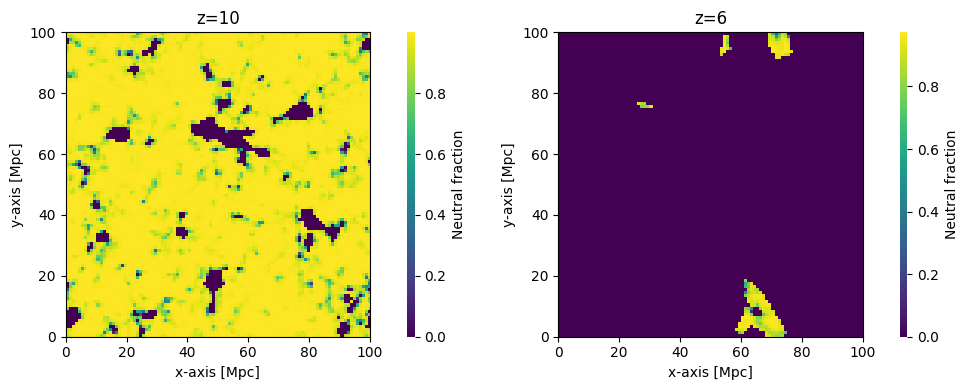

In [10]:
xH_z10 = runcache.get_output_struct_at_z(z=10., kind="IonizedBox")
xH_z6 = runcache.get_output_struct_at_z(z=6., kind="IonizedBox")

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plotting.coeval_sliceplot(xH_z10, ax=ax[0], kind="xH_box")
ax[0].set_title("z=10")
plotting.coeval_sliceplot(xH_z6, ax=ax[1], kind="xH_box")
ax[1].set_title("z=6")
plt.tight_layout();

In fact, we could go further than this, and plot all the evaluated brightness temperatures. We can get the list of redshifts evaluated from the inputs directly as `node_redshifts`:

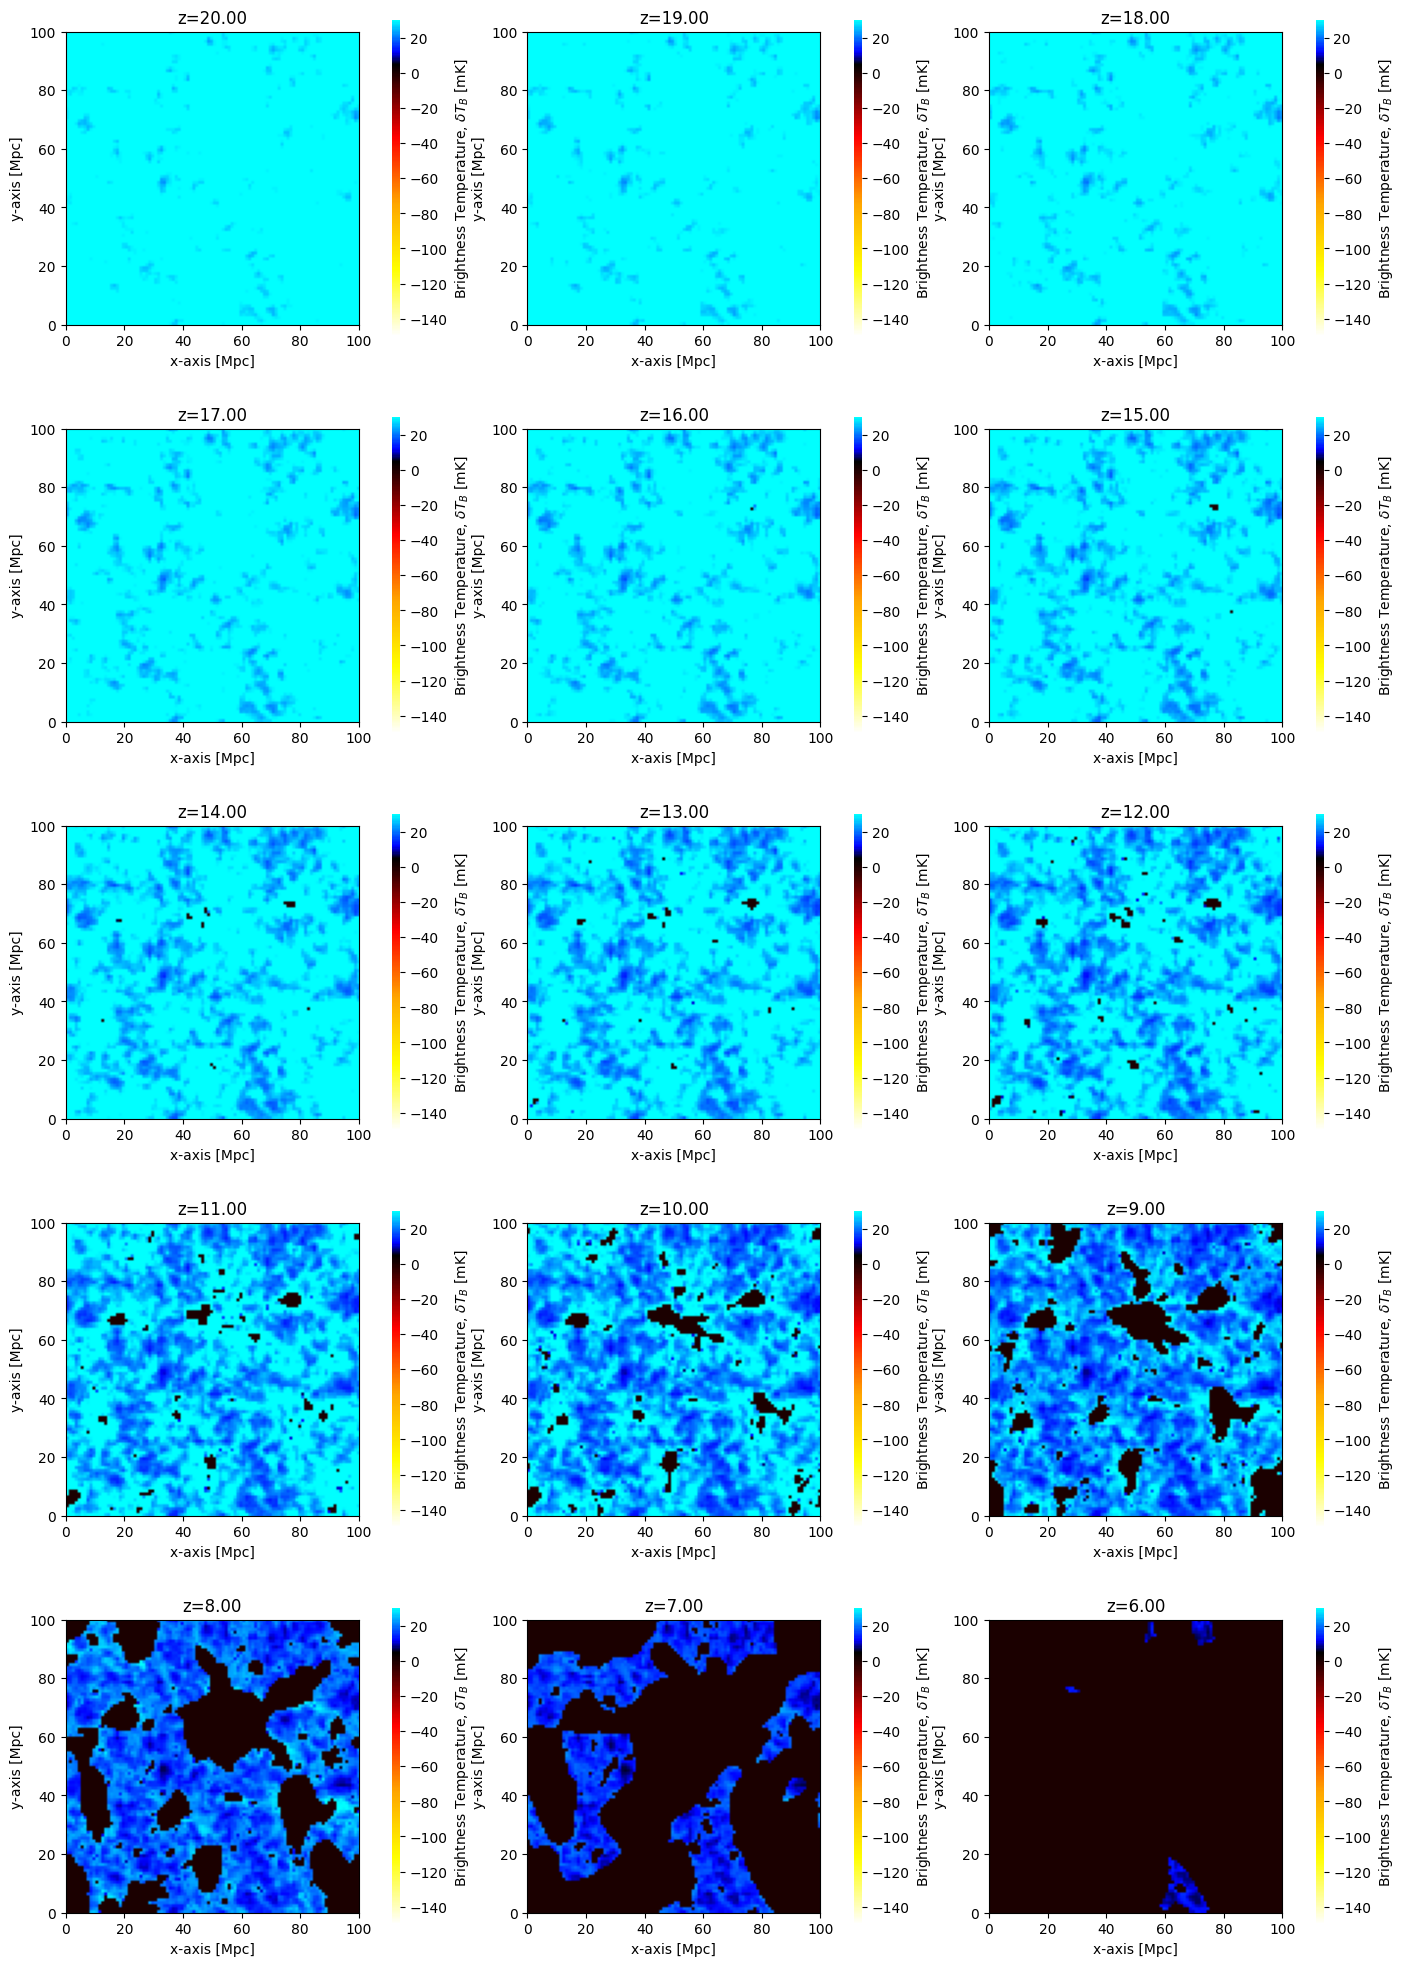

In [11]:
fig, ax = plt.subplots(
    len(inputs.node_redshifts) // 3,
    3,
    figsize=(14, 4 * len(inputs.node_redshifts) // 3),
)

for i, z in enumerate(inputs.node_redshifts):
    Tbz = runcache.get_output_struct_at_z(z=z, kind="BrightnessTemp")
    plotting.coeval_sliceplot(Tbz, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(f"z={z:.2f}")
plt.tight_layout()

We can also directly construct Coeval objects using the cache:

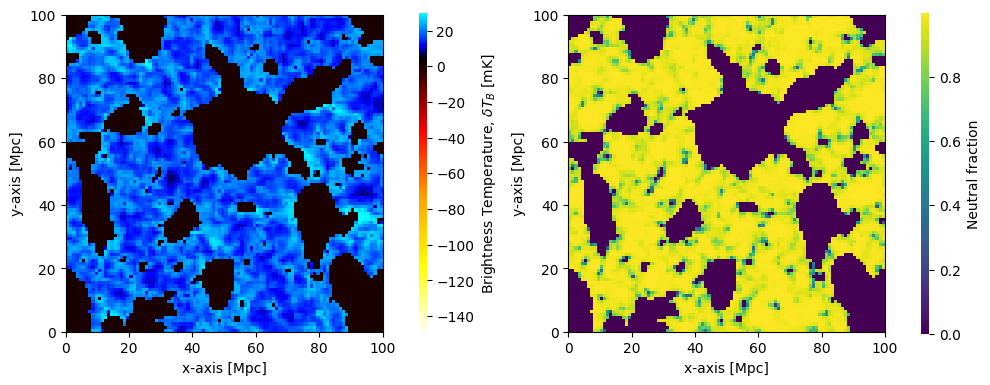

In [12]:
coeval_z16 = runcache.get_coeval_at_z(
    z=8.,
)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plotting.coeval_sliceplot(coeval_z16, ax=ax[0],kind='brightness_temp')
plotting.coeval_sliceplot(coeval_z16, ax=ax[1],kind='xH_box')
plt.tight_layout()

Coevals read in this way do not necessarily have to be in the `out_redshifts` of the coeval run, they can also be in the `node_redshifts`, or even computed in some other run with the same inputs and random seed.